In [1]:
# standard libraries
import numpy as np
import pandas as pd
import re
import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 8]

In [2]:
#Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Algorithms
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDRegressor, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier,  GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from xgboost import XGBRegressor, XGBClassifier

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #regression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score #classification

C:\Users\Dominic Soon\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# prepre processing
# ftds_oct_2018/Projects/BeginnerDataScience/01_getting_data.ipynb

In [4]:
# loading the datasets
# Alternative source: url = 'https://github.com/ohjho/ftds_oct_2018/raw/master/Projects/BeginnerDataScience/data/centadata_clean.csv'
df = pd.read_csv('centadata_clean.csv',index_col=0)

# Centaline index csv, downloaded from Centaline website and adjusted manually to monthly data in Excel
df_index = pd.read_csv('Centaline index cleaned.csv',index_col=0)

In [5]:
df_index.index = pd.to_datetime(df_index.index,format="%d/%m/%Y")

In [6]:
# Drop some not required columns
data = df.drop(['xaxis','yaxis','dateofcompletion','schoolnet','deal_age','deal_year'], axis=1)

In [7]:
# Changing the data categories
data['region'] = data['region'].astype('category')
data['schoolnet_en'] = data['schoolnet_en'].astype('category')
data['flat_type'] = data['flat_type'].astype('category')
# data['txdate'] = data['txdate'].astype('datetime64')
data['txdate'] = pd.to_datetime(data['txdate'],format="%d/%m/%Y")

# take out flat_type and drop the column (there were only 1,000+ records vs. total data of 87,000)
data = data[data.flat_type == 'n']
data = data.drop(['flat_type'], axis=1)

data.shape

(87184, 12)

In [8]:
# checking for duplicates
dup = data[data.duplicated(subset=None,keep='first').sort_values(ascending=False)]
print(len(dup))

# dup.to_csv('dups.csv', encoding='utf-8') 
# data = data.drop_duplicates()
# data.shape

0


C:\Users\Dominic Soon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(87184, 12)

Clean dataset with no dups.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87184 entries, 0 to 101937
Data columns (total 12 columns):
txdate             87184 non-null datetime64[ns]
price              87184 non-null int64
saleablearea       87184 non-null int64
buildingaddress    87184 non-null object
numberofunits      87184 non-null int64
numberoffloors     87184 non-null int64
flatsperfloor      87184 non-null int64
region             87184 non-null category
price_per_sqf      87184 non-null float64
floor_number       87184 non-null int64
building_age       87184 non-null float64
schoolnet_en       87184 non-null category
dtypes: category(2), datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 7.5+ MB


In [10]:
data.describe(include='all')

,txdate,price,saleablearea,buildingaddress,numberofunits,numberoffloors,flatsperfloor,region,price_per_sqf,floor_number,building_age,schoolnet_en
count,87184,8.718400e+04,87184.000000,87184,87184.000000,87184.000000,87184.000000,87184,87184.000000,87184.000000,87184.000000,87184
unique,461,NaN,NaN,9032,NaN,NaN,NaN,56,NaN,NaN,NaN,35
top,2017-04-13 00:00:00,NaN,NaN,51 WING SHUN STREET,NaN,NaN,NaN,Tseung Kwan O,NaN,NaN,NaN,Kowloon district No. 34 school network
freq,498,NaN,NaN,924,NaN,NaN,NaN,5167,NaN,NaN,NaN,6076
first,2017-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2018-11-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.451012e+06,556.067684,NaN,196.231625,25.720706,7.371307,NaN,14254.542548,15.543185,26.626960,NaN
std,NaN,8.971366e+06,286.563151,NaN,142.362608,12.479458,4.172111,NaN,5483.138999,12.337433,16.674961,NaN
min,NaN,5.500000e+05,97.000000,NaN,2.000000,2.000000,1.000000,NaN,1236.954001,0.000000,-1.032170,NaN
25%,NaN,4.520000e+06,378.000000,NaN,86.000000,16.000000,5.000000,NaN,10638.297870,6.000000,14.214921,NaN


In [11]:
# Pre-processing and creating adj psf and indexed to Jan 2017 based on the Centaline index

index_dict = dict()
# iterating the month data and indexed
for index, row in df_index.iterrows(): # in this code, I am getting the indexing from Centaline index csv which I calc
    index_dict.update({index:row['indexed']})

# adding new columns and mapping to get adj psf price
data['mod_date'] = data['txdate'] + pd.offsets.MonthEnd(0)
data['indexed'] = data['mod_date'].map(index_dict)
data['adj_psf_price'] = data['price_per_sqf']/data['indexed']*100
data = data.drop(['mod_date'],axis=1)

In [12]:
# Creating a price cat column for Classifier models based on adj psf price (in case we need it later, which we didn't 
# use except in EDA)

price_cat_array = np.array([5000, 10000, 12000, 15000, 18000, 20000, 25000, 30000, 35000, 40000])
data['psf_cat'] = pd.cut(data['adj_psf_price'], price_cat_array).cat.codes

In [13]:
# re-arrange cols for better reading in EDA
data = data[['txdate','adj_psf_price','price_per_sqf','psf_cat','indexed','price','region','buildingaddress',
             'floor_number','saleablearea', 'building_age',
             'numberofunits','numberoffloors', 'flatsperfloor','schoolnet_en']]

In [14]:
data.head(5)

,txdate,adj_psf_price,price_per_sqf,psf_cat,indexed,price,region,buildingaddress,floor_number,saleablearea,building_age,numberofunits,numberoffloors,flatsperfloor,schoolnet_en
0,2017-02-16,7173.451492,7346.938776,0,102.418463,2880000,Mongkok/Yaumatei,205A TUNG CHOI STREET,2,392,55.301848,8,8,1,Kowloon district No. 32 school network
1,2018-01-11,6594.135630,7653.061224,0,116.058596,3000000,Mongkok/Yaumatei,205A TUNG CHOI STREET,3,392,55.301848,8,8,1,Kowloon district No. 32 school network
2,2017-06-26,24118.770415,26673.640170,5,110.592869,51000000,Happy Valley/Mid Level East,4A-4B WONG NAI CHUNG GAP ROAD,5,1912,53.215606,8,8,1,Hong Kong District No. 12 school network
3,2018-03-21,11501.696560,14115.646260,1,122.726645,4150000,Diamond Hill/Wong Tai Sin,98 TSEUK LUK STREET,16,294,19.882272,30,15,2,Kowloon district No. 43 school network
4,2017-11-28,8776.461186,9905.660377,0,112.866224,5250000,Diamond Hill/Wong Tai Sin,54-58 SOUTH WALL ROAD,8,530,49.133470,32,9,4,Kowloon district No. 41 school network


In [15]:
print(f"No of unique regions: {data['region'].nunique()}")
print(f"No of unique schoolnets: {data['schoolnet_en'].nunique()}")
print(f"No of unique building address: {data['buildingaddress'].nunique()}")
print(f"No of unique price category: {data['psf_cat'].nunique()}")

No of unique regions: 56
No of unique schoolnets: 35
No of unique building address: 9032
No of unique price category: 10


### Simple EDA

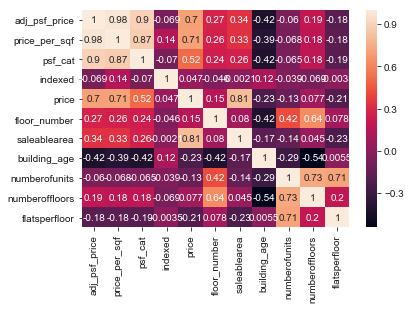

In [16]:
ax = sns.heatmap(data.corr(), annot=True)
sns.set(font_scale=10)

Observations:
* psf price weak -ve corr with building age
* psf price weak +ve corr with floor no and saleable area
* older bldgs then to have lower no of floors and no of units

Obvious stuff:
* Strong +ve corr between no of units and flats per floor and no of floors
* +ve corr between floor no and number of units and floors

== **We will need to one-hot encode to see corr/regressions between psf price and region/schoolnet** ==

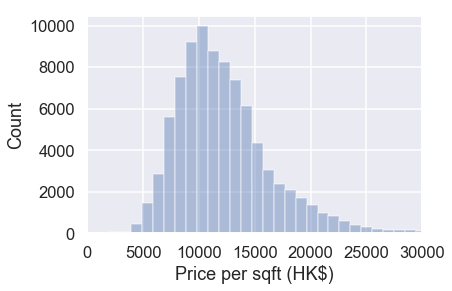

In [40]:
ax = sns.set(style = 'darkgrid', context = 'talk', font_scale= 1)
ax = sns.distplot(data['adj_psf_price'].dropna(), bins=100, label = "Adj. price per sqft (HK$)", kde =False)
ax.set(xlabel="Price per sqft (HK$)", ylabel='Count')
ax.set_xlim(0,30000) # plot exclude outliers
plt.show()

Price psf distribution plot has right skew, but can be described as roughly normal. 

We can do some classification analysis for price ranges: 0: <5K, 1: 10K, 2: 12K, 3: 15K, 4: 18K, 5: 20K, 6: 25K, 7: 30K, 8: 35K, 9: >40K (10 classes). With these classes we can run Classifier models to predict based on street address, region amonng the other factors like saleable area, building age, floor number

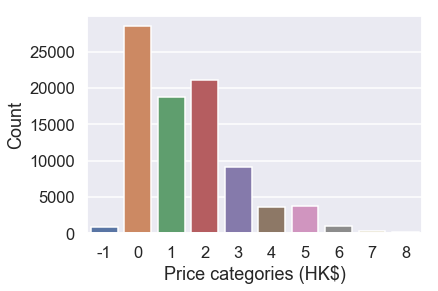

In [18]:
ax = sns.set(style = 'darkgrid', context = 'talk', font_scale= 1)
ax = sns.countplot(x='psf_cat', label = "Price categories", data=data)
ax.set(xlabel="Price categories (HK$)", ylabel='Count')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

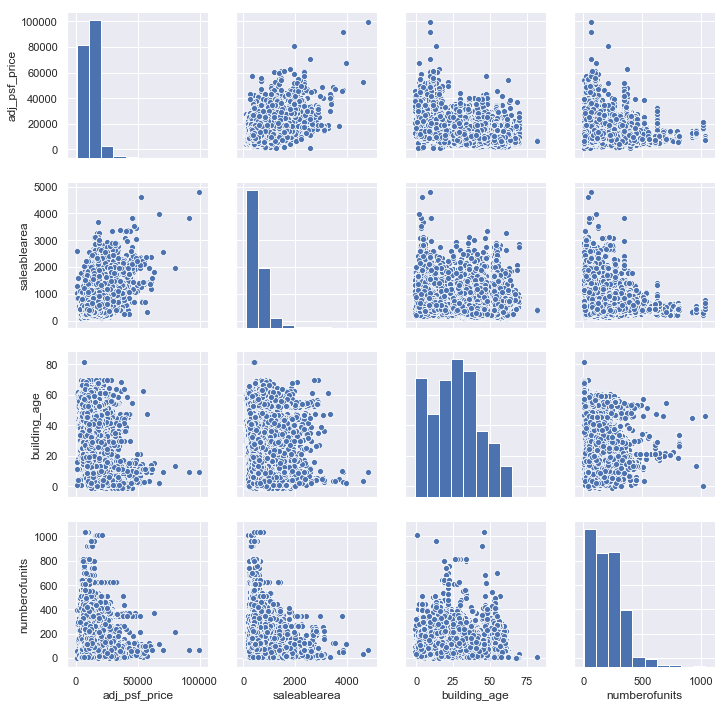

In [19]:
sns.set(style='darkgrid',context='notebook')
cols=['adj_psf_price', 'saleablearea', 'building_age','numberofunits']
sns.pairplot(data[cols])
plt.show()

Our pairplot tells similar story to heatmap of correlation. There is some +ve corr between saleable area and psf price.

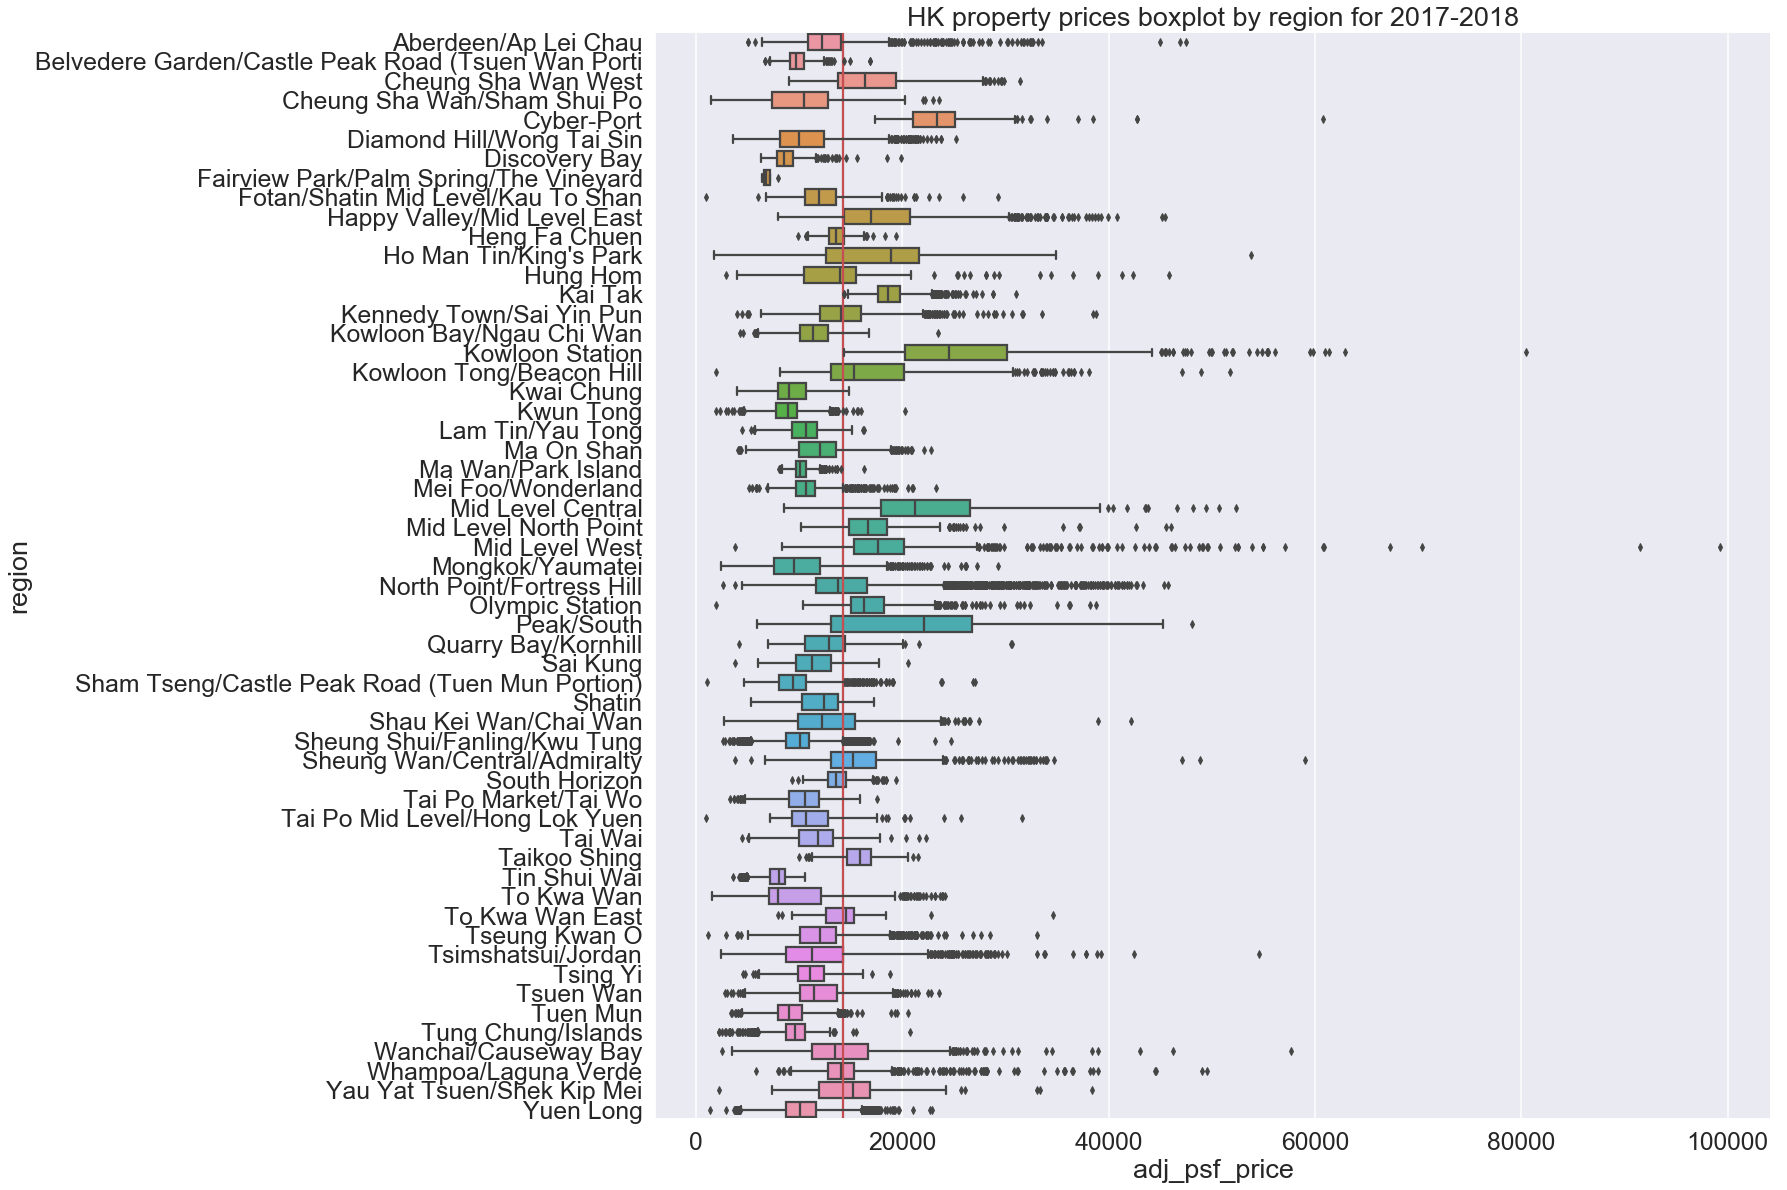

In [20]:
plt.figure(figsize = (20,20))
ax = sns.set(style = 'darkgrid', context = 'talk', font_scale= 1.5)
ax = sns.boxplot(x ='adj_psf_price', y = 'region', data = data )

mean_price = data.price_per_sqf.mean()
ax.vlines( mean_price, ax.get_ylim()[0], ax.get_ylim()[1], color = 'r')
ax.set_title('HK property prices boxplot by region for 2017-2018')
plt.show()

It would be great if we could put the chart in median order. Checked but steps are too complicated to be worth the effort.

Observations:
* Some outliers in several region skewed the dataset a lot
* Standout more expensive areas are Kowloon Stn, Midlevels, Peak, Cyberport
* Cheaper areas are Tin Shui Wai, Fairview Park, Kwun Tong

### Feature engineered EDA

In [21]:
pct_chg_df = data.copy()
pct_chg_df.sort_values(by='txdate', inplace=True)
pct_chg_df = pd.DataFrame(pct_chg_df.groupby(pct_chg_df['txdate'].dt.strftime('%b %Y'), sort=False)['price_per_sqf'].mean())
pct_chg_df['pct_chg'] = pct_chg_df['price_per_sqf'].pct_change()
pct_chg_df['indexed'] = 100*np.exp(np.nan_to_num(pct_chg_df['pct_chg'].cumsum()))

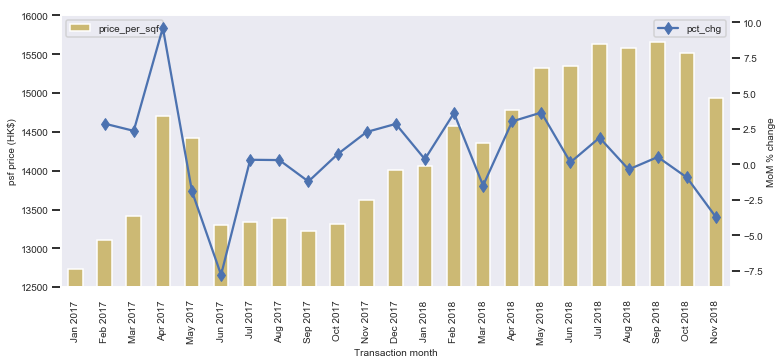

In [22]:
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()
pct_chg_df['price_per_sqf'].plot(kind='bar', x='mod_date', color='y', ax=ax1,use_index=True)
(pct_chg_df['pct_chg']*100).plot(kind='line', x='mod_date', marker='d', ax=ax2,use_index=True)

ax1.set_ylim(12500,16000)
ax1.yaxis.tick_left()
ax1.tick_params(labelsize=10)
ax1.set_ylabel("psf price (HK$)",fontsize=10)
ax1.set_xlabel("Transaction month",fontsize=10)
ax1.grid(False)
ax1.legend(loc=2, fontsize=10)

ax2.yaxis.tick_right()
ax2.tick_params(labelsize=10)
ax2.set_ylabel("MoM % change",fontsize=10)
ax2.grid(False)
ax2.legend(loc=1, fontsize=10)

plt.show()

Observation: Overall market seen steady increase in psf price since Q317 and declined in Q418.

### Increase dimensions and one hot encode

In [26]:
# Hot encode regions

region_dummies = pd.get_dummies(data['region'], prefix='reg',prefix_sep='_')
region_dummies.index = data.index
region_dummies.shape

(87184, 56)

In [27]:
region_data = data.join(region_dummies)

In [28]:
# region_data.to_csv('Centaline_region.csv')

### Regression model training (only encoded region for now)

In [29]:
region_data = region_data.sort_values(by='txdate')

In [30]:
#creating a validation test data for Nov transactions

region_data_test = region_data[region_data['txdate'] < '2018-10-31']
region_data_val = region_data[region_data['txdate'] > '2018-10-31']
print(f'Shapes of data set: {region_data_test.shape} and validation set: {region_data_val.shape}')

Shapes of data set: (86548, 71) and validation set: (568, 71)


We take out the Nov transactions for our validation data set.

In [31]:
# Sperate train and test data
X = region_data_test.drop(['txdate','adj_psf_price','price_per_sqf','psf_cat','indexed','price','region','buildingaddress','schoolnet_en'], axis=1)
y = region_data_test['adj_psf_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
print(f'X_train shape {X_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape {y_test.shape}')


X_train shape (60583, 62)
X_test shape (25965, 62)
y_train shape (60583,)
y_test shape (25965,)


In [33]:
# models to run 

models = [LinearRegression(),  Lasso(alpha=1.0), XGBRegressor(random_state=1),DecisionTreeRegressor(),
          RandomForestRegressor(n_estimators=100, random_state=1), GradientBoostingRegressor()]

# redundant models:  SGDRegressor(random_state=1), Ridge(alpha=1.0), SVR()

results_cols=['Model', 'MAE','MSE','R2']
results_df = pd.DataFrame(columns=results_cols)

for lm in models:
    lm.fit(X_train, y_train)
    name = lm.__class__.__name__
    print("="*30)
    print(name)
    
    print('****Results****')
    y_pred = lm.predict(X_test)
    MAE = round(mean_absolute_error(y_test, y_pred),2)
    MSE = round(mean_squared_error(y_test, y_pred),2)
    R2 = round(r2_score(y_test, y_pred) * 100 ,2)
    print(f'Mean abs error: {MAE}')
    print(f'Mean sq error: {MSE}')
    print(f'R2: {R2}%')
    
    results_entry = pd.DataFrame([[name, MAE, MSE,R2]], columns=results_cols)
    results_df = results_df.append(results_entry)


LinearRegression
****Results****
Mean abs error: 1881.26
Mean sq error: 7595431.36
R2: 66.25%
Lasso
****Results****
Mean abs error: 1881.57
Mean sq error: 7609150.41
R2: 66.18%
XGBRegressor
****Results****
Mean abs error: 1722.54
Mean sq error: 6285058.18
R2: 72.07%
DecisionTreeRegressor
****Results****
Mean abs error: 1094.88
Mean sq error: 3497012.84
R2: 84.46%
RandomForestRegressor
****Results****
Mean abs error: 866.85
Mean sq error: 2212556.04
R2: 90.17%
GradientBoostingRegressor
****Results****
Mean abs error: 1719.31
Mean sq error: 6318379.14
R2: 71.92%


In [34]:
results_df = results_df.set_index('Model')
results_df = results_df.sort_values(by='R2', ascending=False)
results_df

,MAE,MSE,R2
Model,,,
RandomForestRegressor,866.85,2212556.04,90.17
DecisionTreeRegressor,1094.88,3497012.84,84.46
XGBRegressor,1722.54,6285058.18,72.07
GradientBoostingRegressor,1719.31,6318379.14,71.92
LinearRegression,1881.26,7595431.36,66.25
Lasso,1881.57,7609150.41,66.18


Random Forest Regressor gives us the best R2 result of >90%.

In [36]:
# Retraining the model on whole data set and then check R2 on the validation set

X_deploy = region_data_test.drop(['txdate','adj_psf_price','price_per_sqf','psf_cat','indexed','price','region','buildingaddress','schoolnet_en'], axis=1)
y_deploy = region_data_test['adj_psf_price']

X_val = region_data_val.drop(['txdate','adj_psf_price','price_per_sqf','psf_cat','indexed','price','region','buildingaddress','schoolnet_en'], axis=1)
y_val = region_data_val['adj_psf_price']

print(f'X_deploy shape {X_deploy.shape}')
print(f'X_val shape {X_val.shape}')
print(f'y_deploy shape {y_deploy.shape}')
print(f'y_val shape {y_val.shape}')


X_deploy shape (86548, 62)
X_val shape (568, 62)
y_deploy shape (86548,)
y_val shape (568,)


In [37]:
rf_deploy = RandomForestRegressor(n_estimators=100, random_state=1)
rf_deploy.fit(X_deploy, y_deploy)

y_pred_deploy = rf_deploy.predict(X_val)

RFMAE = round(mean_absolute_error(y_val, y_pred_deploy),2)
RFMSE = round(mean_squared_error(y_val, y_pred_deploy),2)
RFR2 = round(r2_score(y_val, y_pred_deploy) * 100 ,2)
print(f'Mean abs error: {RFMAE}')
print(f'Mean sq error: {RFMSE}')
print(f'R2: {RFR2}%')

Mean abs error: 1205.9
Mean sq error: 3698175.17
R2: 77.7%


Above shows that our out of bag data gets only 78% accuracy compared to in sample.

In [ ]:
#k-fold validation on best model, which is the RF

# r2_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring = "r2", n_jobs=-1)

# print(r2_scores)
# print("R2: %0.2f (+/- %0.2f)" % (r2_scores.mean(), r2_scores.std() * 2))

[0.89595857 0.88828477 0.892234   0.88791049]
R2: 0.89 (+/- 0.01)

In [43]:
# feature importance
importances = pd.DataFrame({'feature':X_deploy.columns,'importance':np.round(rf_deploy.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [44]:
importances.head(10)

,importance
feature,
building_age,0.299
saleablearea,0.181
floor_number,0.060
numberoffloors,0.059
reg_Mid Level West,0.039
numberofunits,0.038
reg_Kowloon Station,0.036
flatsperfloor,0.034
reg_North Point/Fortress Hill,0.029


# DO NOT RUN!!! Cross validation hyper parameter tuning

param_grid = { "criterion" : ["mse", "mae"], 
              "min_samples_leaf" : [1, 5, 10, 25, 50], 
              "min_samples_split" : [2, 4, 10, 12, 16, 18, 25], 
              "n_estimators": [100, 250, 500]}


from sklearn.model_selection import GridSearchCV, cross_val_score

rf = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=False, random_state=1, n_jobs=-1)

clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

clf.fit(X_train, y_train) 

clf.best_params_

# NOT REQUIRED CODE

In [23]:
# def PCA_analysis(data, comp_no):
#     scaler = StandardScaler()
#     scaled_data_dummies = scaler.fit_transform(data)
#     pca = PCA(n_components=comp_no)
#     PCA_data = pca.fit_transform(scaled_data_dummies)
#     cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
#     return PCA_data, cumulative_explained_variance[-1:]

In [24]:
# PCA_region = PCA_analysis(region_dummies,50)[0]
# PCA_cum_exp_var = PCA_analysis(region_dummies,50)[1]
# print(f'Cumulative explained variance {PCA_cum_exp_var}.')

In [25]:
# # Put PC_items into a dataframe
# PCA_region = pd.DataFrame(PCA_region)
# # Name the columns
# PCA_region.columns = ['PC{}'.format(i+1) for i in range(PCA_region.shape[1])]
# # Update its index
# PCA_region.index = data.index
# # Display first 5 rows
# PCA_region.head()